<a href="https://www.kaggle.com/code/giuliobenedetti/ml-for-parkinson?scriptVersionId=164253185" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# If TPU is available
try:
    # Detect TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())

except:
    tpu = None
    

# If TPU is defined
if tpu:
    # Initialise TPU
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Instantiate a TPU distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    # Or instanstiate available strategy
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
base_dir = "/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/"
tdcsfog_dir = base_dir + "train/tdcsfog/"

samples = []

# Read in samples
for file in os.listdir(tdcsfog_dir):
    samples.append(pd.read_csv(tdcsfog_dir + file, index_col=0))

m = len(samples)
print(f"Number of sessions: {m}")

Number of sessions: 833


In [4]:
patches = []
window = 3000
step = 1500
stride = 1

for sample in samples:
    
    pad_idx = step - (sample.shape[0] - window) % step
    padded_sample = pd.concat([sample, sample[:pad_idx]])

    for i in range((padded_sample.shape[0] - window) // step):
        patch = padded_sample[i * step:i * step + window:stride]
        patches.append(patch)

raw_ds = np.array(patches)

print(f"Size of train set: {raw_ds.shape[0]}")

Size of train set: 3462


In [5]:
# Store feature columns into X array
raw_X = raw_ds[:, :, :3]
# Store target columns into y array
y = raw_ds[:, :, 3:]

input_shape = raw_X[0].shape
print(f"Input Shape: {input_shape}")

Input Shape: (3000, 3)


In [6]:
# Find triplette of minima for every sample
min_arr = np.min(raw_X, axis=1, keepdims=True)
# Find triplette of maxima for every sample
max_arr = np.max(raw_X, axis=1, keepdims=True)
# Normalise with MinMax rescaling
X = (raw_X - min_arr) / (max_arr - min_arr)

print(f"Min and Max before Norm: {np.min(raw_X):.1f} and {np.max(raw_X):.1f}")
print(f"Min and Max after Norm: {np.min(X)} and {np.max(X)}")

Min and Max before Norm: -35.8 and 29.3
Min and Max after Norm: 0.0 and 1.0


In [7]:
print("Input Example:")
print("\n")

print("Feature series:")
print(X[0])
print("\n")

print("Target series:")
print(y[0])

Input Example:


Feature series:
[[0.58246059 0.689469   0.39791782]
 [0.58202358 0.68991615 0.39791227]
 [0.58219078 0.68887005 0.39842336]
 ...
 [0.72528125 0.64892527 0.61998842]
 [0.66777942 0.70944199 0.56558153]
 [0.58878806 0.76293988 0.50032901]]


Target series:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [8]:
devel_fraction = 0.1

devel_idx = np.random.choice(len(X), int(devel_fraction * len(X)), replace=False)
train_idx = np.setdiff1d(np.arange(len(X)), devel_idx)

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((X[train_idx], y[train_idx])).batch(32)
devel_ds = tf.data.Dataset.from_tensor_slices((X[devel_idx], y[devel_idx])).batch(32)

In [10]:
# Set up model within scope of tpu strategy
with strategy.scope():

    # Design LSTM model with one recurrent layer
    model = keras.Sequential([
        layers.Bidirectional(layers.LSTM(32, return_sequences=True, input_shape=input_shape), merge_mode="ave"),
        layers.Dense(3, activation="softmax")
    ])

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )

In [11]:
learning_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    mode="min")


# Train model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=2,
    callbacks=[learning_scheduler, early_stopping],
    verbose=True
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['categorical_accuracy'].iloc[-1]:.3f}")

Epoch 1/2
98/98 [==============================] - 19s 138ms/step - loss: 0.3137 - categorical_accuracy: 0.3132 - val_loss: 0.3372 - val_categorical_accuracy: 0.3277 - lr: 0.0100
Epoch 2/2
98/98 [==============================] - 13s 131ms/step - loss: 0.3138 - categorical_accuracy: 0.3100 - val_loss: 0.3312 - val_categorical_accuracy: 0.3277 - lr: 0.0100
Train loss: 0.314
Train accuracy: 0.310


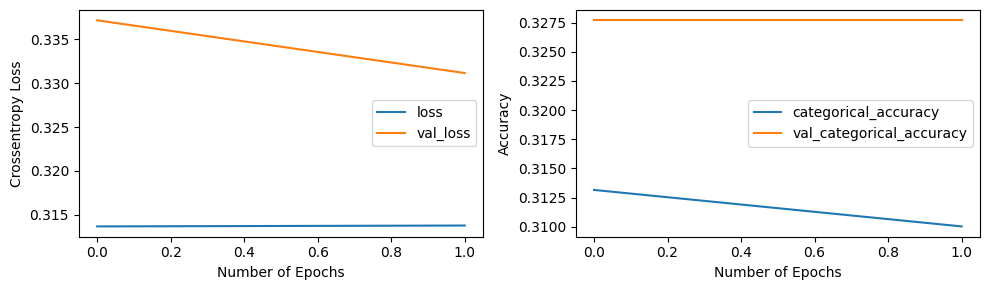

In [12]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise performance
history_df.loc[:, ["loss", "val_loss"]].plot(ax=axes[0])
axes[0].set_xlabel("Number of Epochs")
axes[0].set_ylabel("Crossentropy Loss")

history_df.loc[:, ["categorical_accuracy", "val_categorical_accuracy"]].plot(ax=axes[1])
axes[1].set_xlabel("Number of Epochs")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()

In [13]:
# Store test id
test_id = "003f117e14"
# Read in test session
test_sample = pd.read_csv(base_dir + "test/tdcsfog/" + test_id + ".csv")

# Predict labels
y_pred = model.predict(test_sample.drop("Time", axis=1).to_numpy().reshape(1, -1, 3)).reshape(-1, 3)

print(f"Predicted time points: {y_pred.shape[1]}")
print("Example Predictions:")
print(y_pred)

1/1 [==============================] - 1s 1s/step
Predicted time points: 3
Example Predictions:
[[0.36207226 0.29766977 0.340258  ]
 [0.3597387  0.29905322 0.34120813]
 [0.35610133 0.30055416 0.34334454]
 ...
 [0.35227954 0.2971874  0.35053304]
 [0.35267216 0.29734248 0.3499854 ]
 [0.35214525 0.29946125 0.34839353]]


In [14]:
# Collect predictions into dataframe
submission_df = pd.DataFrame(
    y_pred,
    columns=["StartHesitation", "Turn", "Walking"]
)

# Produce Id column
id_col = [test_id + "_" + str(i) for i in range(submission_df.shape[0])]
# Add Id column to dataframe
submission_df.insert(0, "Id", id_col)

# Write submission file
submission_df.to_csv("/kaggle/working/submission.csv", index=False)